In [1]:
from deeprxn.featurizer import make_featurizer
from deeprxn.utils import set_seed, load_standardizer, load_model
from deeprxn.train import predict
from torch_geometric.utils import subgraph
from deeprxn.data import AtomOriginType, Standardizer
from omegaconf import OmegaConf
from hydra import initialize, compose
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import hydra
import os
os.chdir('..')

In [2]:
import torch
from torch_geometric.utils import to_dense_batch
x = torch.arange(12).view(6, 2)
batch = torch.tensor([0, 0, 1, 3, 3, 3])
out, mask = to_dense_batch(x, batch=None, max_num_nodes=2)
print(x)
print(out)
print(mask)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]])
tensor([[[0, 1],
         [2, 3]]])
tensor([[True, True]])


# TODO: write script that automatically visualizes graph of given config
### TODO: update code

In [11]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    OmegaConf.set_struct(cfg, False)
    #print(OmegaConf.to_yaml(cfg))

set_seed(cfg.seed)

cfg.features.atom_featurizer = "atom_rdkit_organic"
cfg.features.bond_featurizer = "bond_rdkit_base"
atom_featurizer = make_featurizer(cfg.features.atom_featurizer)
bond_featurizer = make_featurizer(cfg.features.bond_featurizer)
cfg.data.dataset_name = "barriers_rdb7" # "barriers_e2", "barriers_rdb7"
cfg.transformation.representation = "connected_pair" # connected_pair, CGR
cfg.transformation.connection_direction = "bidirectional" # None, bidirectional, reactants_to_products, products_to_reactants
cfg.transformation.dummy_node = None # global, all_separate, reactant_product, None
cfg.transformation.batch_size = 3

# train_loader = hydra.utils.instantiate(
#     cfg.transformation, shuffle=True, split="train"
# )
test_loader = hydra.utils.instantiate(
    cfg.transformation, shuffle=False, split="test"
)
data = next(iter(test_loader))

# model
cfg.model.num_node_features = test_loader.dataset.num_node_features
cfg.model.num_edge_features = test_loader.dataset.num_edge_features
cfg.model.depth = 3
cfg.model.hidden_size = 300
cfg.model.dropout = 0.02
cfg.model.pool_type = "global"
cfg.model.return_attention_weights = True
cfg.model.shared_weights = True
cfg.model.use_attention_agg = True

model = hydra.utils.instantiate(cfg.model)
#print(model)

In [12]:
cfg.model_path = "saved_models/full/"
model_path = os.path.join(cfg.model_path, "model.pt")
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])
epoch = checkpoint["epoch"]
best_val_loss = checkpoint["best_val_loss"]
mean, std = load_standardizer(cfg.model_path)
stdzer = Standardizer(mean, std)
model.eval()
with torch.no_grad():
    output = model(data)
    
print("Got output of type:", type(output))
print("Output shape:", [t.shape if torch.is_tensor(t) else type(t) for t in output])

Got output of type: <class 'tuple'>
Output shape: [torch.Size([3]), torch.Size([1, 222, 148])]


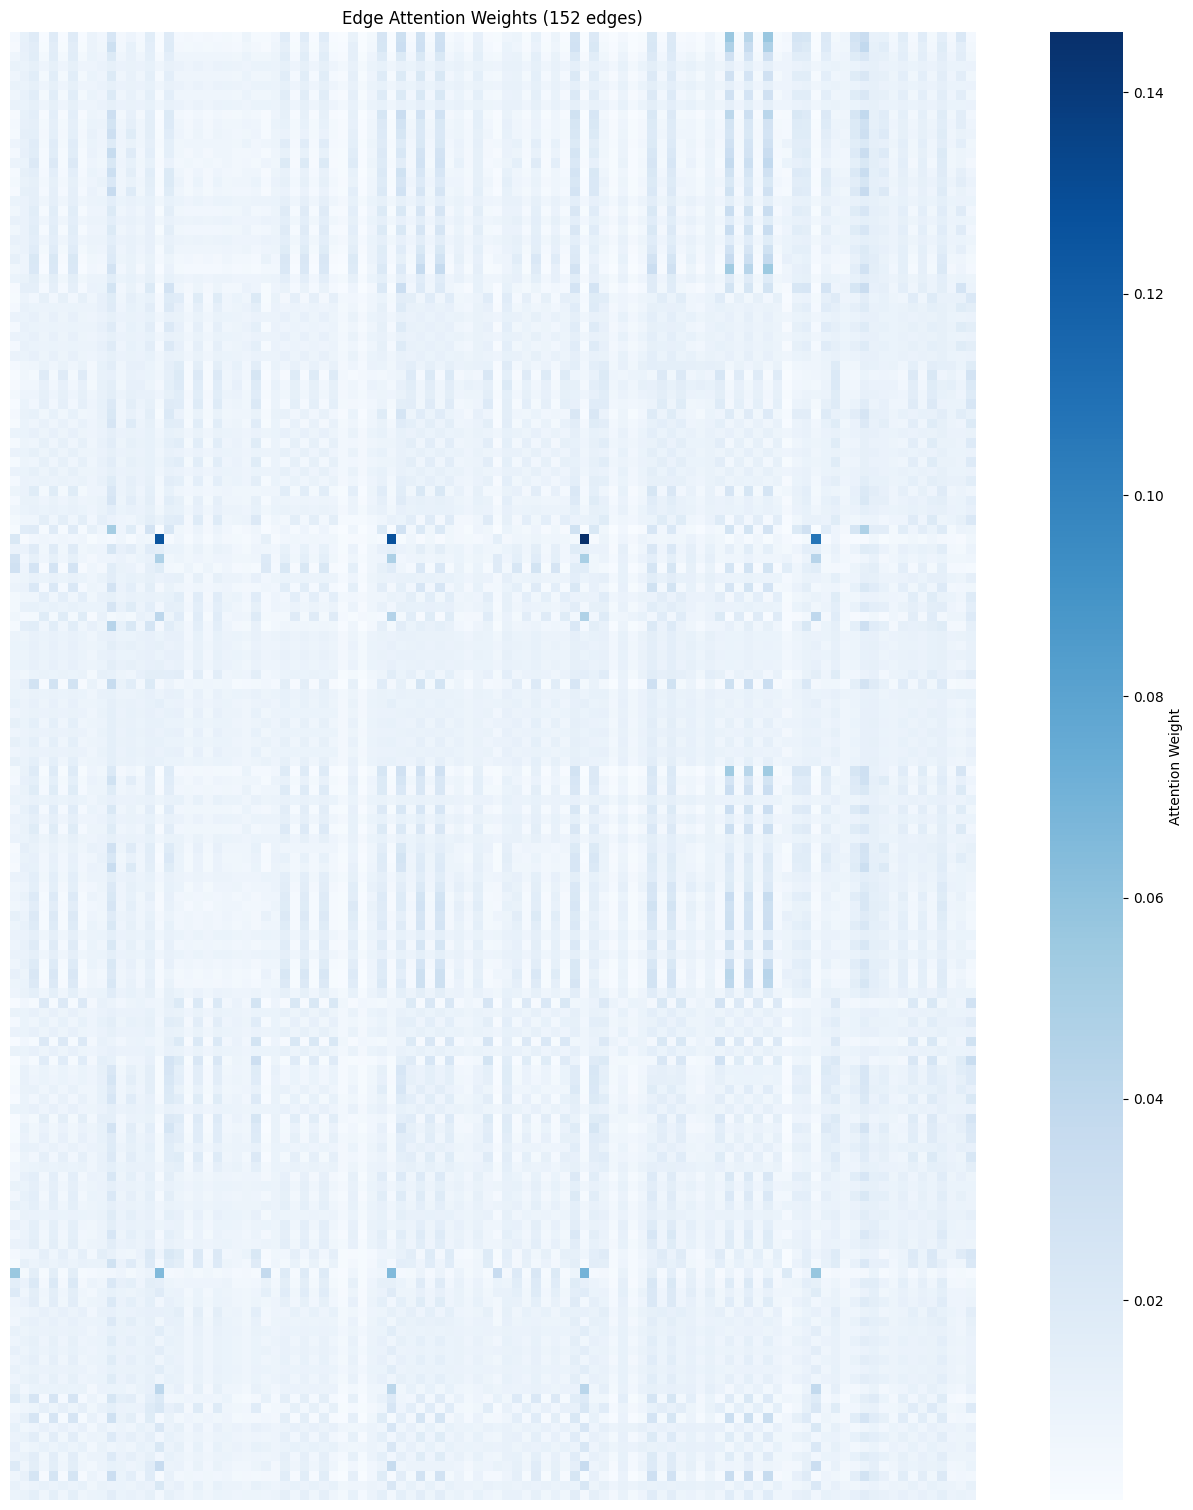

In [10]:
import numpy as np
import seaborn as sns

def plot_attention_heatmap(attention_weights):
    """
    Creates a heatmap visualization of attention weights for large graphs
    
    Args:
        attention_weights: tensor of shape [num_heads, num_edges, max_edges_per_node]
    """
    # Get weights from first head and convert to numpy
    weights = attention_weights[0].numpy()
    
    # Create figure with appropriate size scaling
    scale = max(8, min(20, weights.shape[0] / 10))  # Dynamic figure scaling
    plt.figure(figsize=(scale, scale))
    
    # Create heatmap without labels
    sns.heatmap(
        weights,
        cmap='Blues',
        xticklabels=False,
        yticklabels=False,
        cbar_kws={'label': 'Attention Weight'},
        square=True  # Make cells square
    )
    
    # Add minimal labels
    plt.title(f'Edge Attention Weights ({weights.shape[0]} edges)')
    
    # Adjust layout
    plt.tight_layout()
    
    return plt.gcf()

# Get attention weights from output
_, attention_weights = output

# Create and show heatmap
fig = plot_attention_heatmap(attention_weights)
plt.show()

In [7]:
sample = data

print(f"Node features [num_atoms, num_atom_feat]: {sample.x.shape}")
print(f"Edge index [2, num_bond]: {sample.edge_index.shape}")
print(f"Edge attributes [num_bond, num_bond_feat]: {sample.edge_attr.shape}")
print(f"Target label: {sample.y.shape}")
print(f"Atom origin type: {sample.atom_origin_type.shape}")
print(f"Is real bond: {sample.is_real_bond.shape}, real bonds: {sample.is_real_bond.sum()}, fake bonds: {(~sample.is_real_bond).sum()}")

Node features [num_atoms, num_atom_feat]: torch.Size([26, 44])
Edge index [2, num_bond]: torch.Size([2, 76])
Edge attributes [num_bond, num_bond_feat]: torch.Size([76, 11])
Target label: torch.Size([1])
Atom origin type: torch.Size([26])
Is real bond: torch.Size([76]), real bonds: 50, fake bonds: 26


In [22]:
row = sample.edge_index[0]
edge_batch = sample.batch[row]
edge_batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
from typing import Literal, Optional, Tuple

import torch
from torch import nn
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.norm import LayerNorm
from torch_geometric.utils import to_dense_batch
import torch.nn.functional as F
from deeprxn.data import AtomOriginType

lin_real = nn.Linear(300, 300)
lin_artificial = (
    nn.Linear(300, 300)
)
attention = nn.MultiheadAttention(
            300,
            num_heads=1,
            dropout=0.02,
            batch_first=True,
        )

edge_init = nn.Linear(train_loader.dataset.num_node_features + train_loader.dataset.num_edge_features, 300)

x = data.x
edge_index = data.edge_index
edge_attr = data.edge_attr
batch = data.batch
atom_origin_type = data.atom_origin_type
incoming_edges_list = data.incoming_edges_list
incoming_edges_batch = data.incoming_edges_batch
edge_batch = torch.unique(incoming_edges_batch, sorted=False)
row, col = edge_index
h_0 = F.relu(edge_init(torch.cat([x[row], edge_attr], dim=1)))
h = h_0

In [12]:
edge_attr = h
row, col = edge_index
max_edges_per_node = 4
edge_attr_2 = edge_attr[edge_batch]
edge_attr_dense, mask_edge_attr_dense = to_dense_batch(
    edge_attr_2, batch=edge_batch, batch_size=len(edge_attr)
) # [num_batches, max_nodes_per_batch, hidden_size]
edge_attr_rearranged = edge_attr[incoming_edges_list]
# [num_batches, max_nodes_per_batch, hidden_size], [num_batches, max_nodes_per_batch]
incoming_edges, mask = to_dense_batch(
    edge_attr_rearranged,
    batch=incoming_edges_batch,
    max_num_nodes=max_edges_per_node,
    batch_size=len(edge_attr),
)
# Q: single edges, K: respective incoming edges, V: respective incoming edges
edge_attr_dense_updated, _ = attention(
    edge_attr_dense,
    incoming_edges,
    incoming_edges,
    key_padding_mask=~mask,
    need_weights=False,
)
edge_attr_dense_updated = edge_attr_dense_updated[mask_edge_attr_dense]
# residual connection
edge_attr_att_output = edge_attr.clone()
edge_attr_att_output[edge_batch] = (
    edge_attr_att_output[edge_batch] + edge_attr_dense_updated
)
edge_attr_att_output

tensor([[ 0.0000,  0.0000,  0.0686,  ...,  0.0206,  0.0000,  0.0000],
        [-0.0199,  0.1403, -0.0680,  ..., -0.0039, -0.1153, -0.0495],
        [-0.0243,  0.1344, -0.0601,  ...,  0.0044, -0.0817, -0.0502],
        ...,
        [ 0.0000,  0.0694,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1622,  0.2699, -0.0451,  ..., -0.0435, -0.0347, -0.1579],
        [ 0.0000,  0.1613,  0.0000,  ...,  0.0000,  0.1918,  0.0000]],
       grad_fn=<IndexPutBackward0>)

### Connected pair visualization

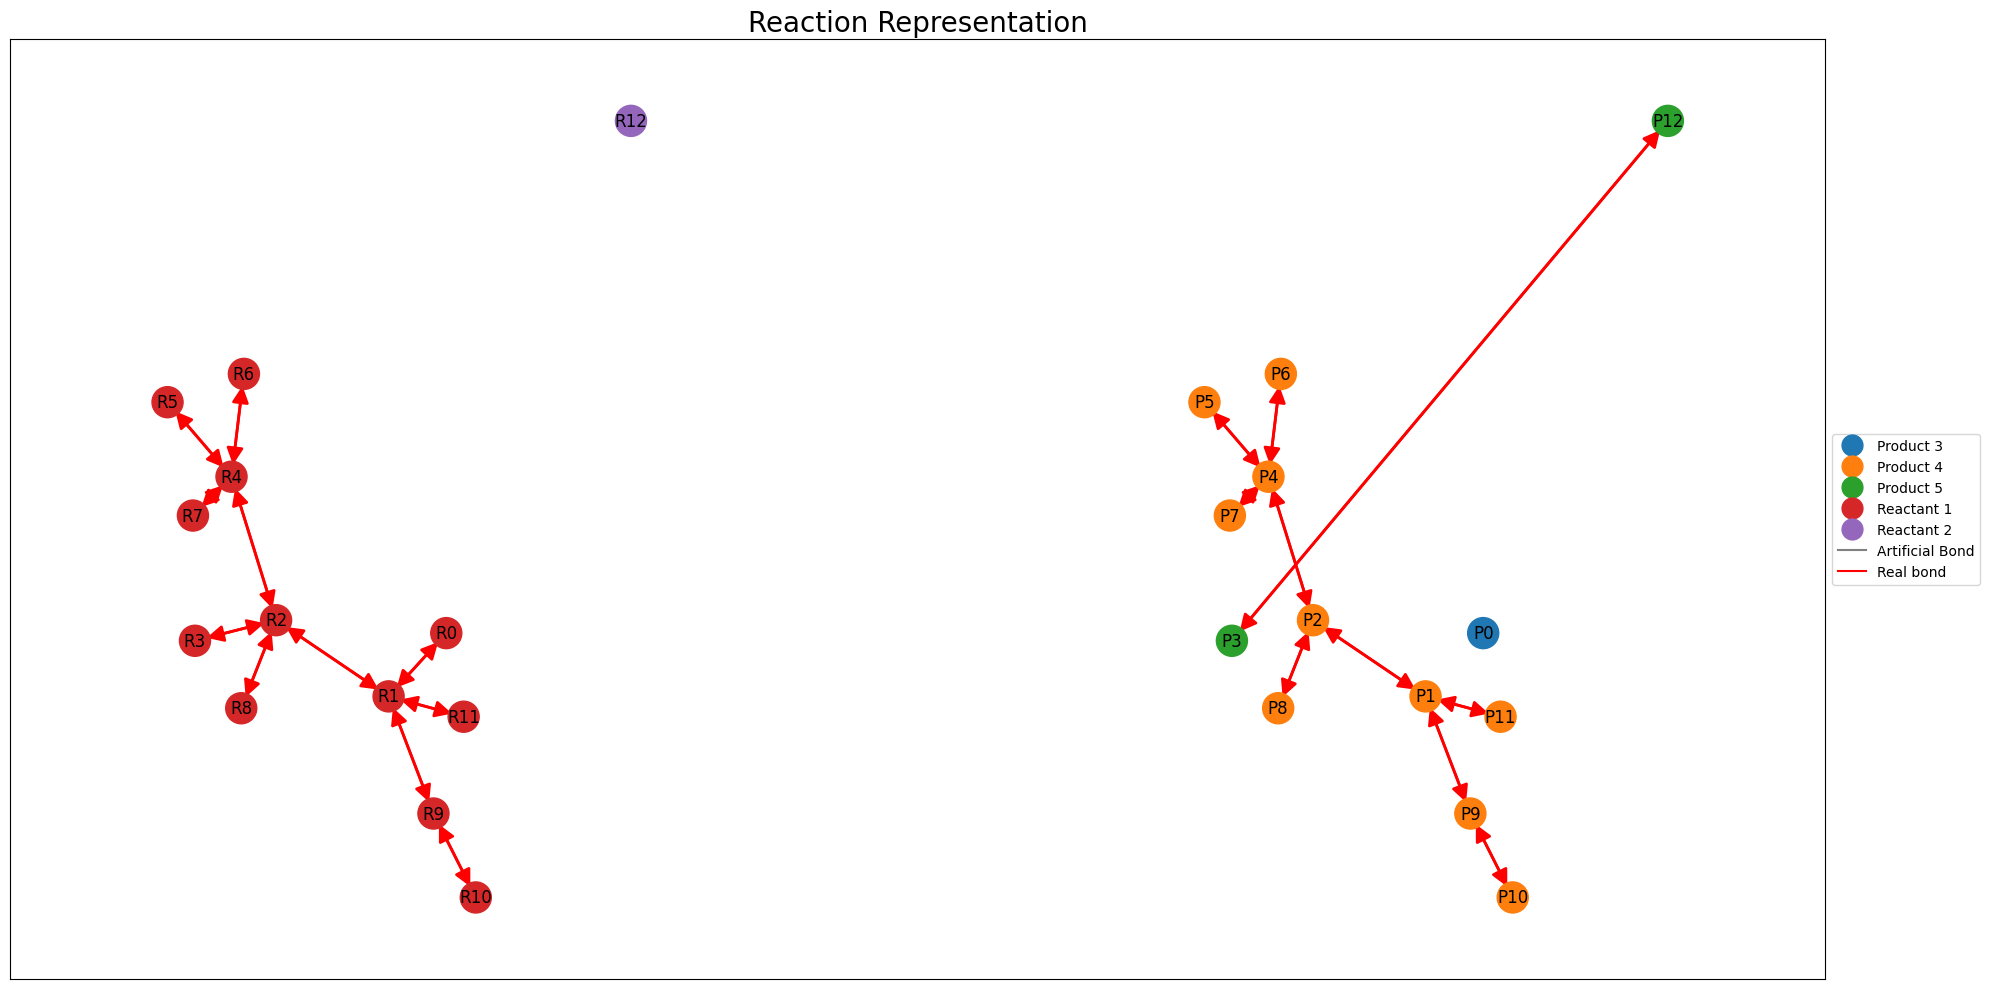

In [6]:
def generate_color_palette(n):
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    return base_colors * (n // len(base_colors) + 1)

def split_data(data):
    reactant_mask = data.atom_origin_type == AtomOriginType.REACTANT
    product_mask = data.atom_origin_type == AtomOriginType.PRODUCT
    
    reactants = data.clone()
    reactants.x = data.x[reactant_mask]
    reactants.edge_index, reactants.edge_attr = subgraph(reactant_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    products = data.clone()
    products.x = data.x[product_mask]
    products.edge_index, products.edge_attr = subgraph(product_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    return reactants, products

def create_graph(data):
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))
    edge_index = data.edge_index.t().tolist()
    G.add_edges_from(edge_index)
    return G

def position_nodes(G_reactants, G_products, G_full):
    pos_reactants = nx.spring_layout(G_reactants, seed=42)
    
    max_x = max(pos[0] for pos in pos_reactants.values())
    
    shift = max_x + 2.0
    
    pos_products = {node + len(G_reactants): (x + shift, y) for node, (x, y) in pos_reactants.items()}
    
    pos_combined = pos_reactants.copy()
    pos_combined.update(pos_products)
    
    dummy_nodes = [node for node in G_full.nodes() if data.atom_origin_type[node] == AtomOriginType.DUMMY]
    if dummy_nodes:
        dummy_x_center = (max_x + shift) / 2
        dummy_y = 0
        dummy_x_spread = 0.2
        for i, dummy_node in enumerate(dummy_nodes):
            offset = (i - (len(dummy_nodes) - 1) / 2) * dummy_x_spread
            pos_combined[dummy_node] = (dummy_x_center + offset, dummy_y)
    
    return pos_combined

def visualize_graphs(data):
    reactants, products = split_data(data)

    G_reactants = create_graph(reactants)
    G_products = create_graph(products)
    G_full = create_graph(data)

    pos_combined = position_nodes(G_reactants, G_products, G_full)

    fig, ax = plt.subplots(figsize=(20, 10))

    atom_groups = []
    for atom_type, atom_origin in zip(data.atom_origin_type, data.atom_origins):
        if atom_type == AtomOriginType.DUMMY:
            atom_groups.append('Dummy')
        elif atom_type == AtomOriginType.REACTANT:
            atom_groups.append(f'Reactant {atom_origin + 1}')
        else:
            atom_groups.append(f'Product {atom_origin + 1}')

    unique_groups = sorted(set(atom_groups))
    color_palette = generate_color_palette(len(unique_groups))
    color_map = dict(zip(unique_groups, color_palette))
    
    node_color_map = [color_map[group] for group in atom_groups]

    nx.draw_networkx_nodes(G_full, pos_combined, ax=ax, node_color=node_color_map, node_size=500)

    labels = {}
    reactant_count = 0
    product_count = 0
    dummy_count = 0
    for i, atom_type in enumerate(data.atom_origin_type):
        if atom_type == AtomOriginType.DUMMY:
            labels[i] = f'D{dummy_count}'
            dummy_count += 1
        elif atom_type == AtomOriginType.REACTANT:
            labels[i] = f'R{reactant_count}'
            reactant_count += 1
        else:
            labels[i] = f'P{product_count}'
            product_count += 1

    nx.draw_networkx_labels(G_full, pos_combined, labels, ax=ax, font_size=12)

    non_real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if not real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=non_real_edges, edge_color='gray', arrows=True, arrowsize=25, width=1.5)

    real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=real_edges, edge_color='r', arrows=True, arrowsize=25, width=2)

    for group, color in color_map.items():
        ax.plot([], [], color=color, marker='o', markersize=15, linestyle='', label=group)
    ax.plot([], [], 'gray', label='Artificial Bond')
    ax.plot([], [], 'r-', label='Real bond')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title("Reaction Representation", fontsize=20)
    plt.tight_layout()
    plt.show()

visualize_graphs(sample)

### For now, CGR

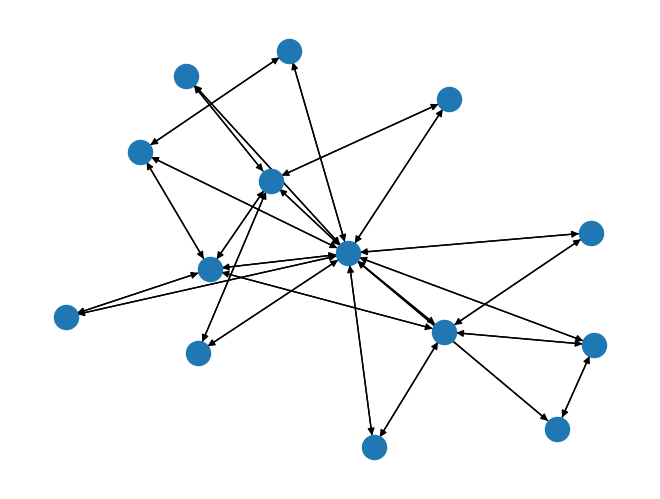

In [14]:
def create_graph(data):
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))
    edge_index = data.edge_index.t().tolist()
    G.add_edges_from(edge_index)
    return G

G = create_graph(sample)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos)

In [11]:
# class RxnGraph:
#     # TODO: add docstring
#     # TODO (maybe): add support for unbalanced reactions?
#     def __init__(
#         self,
#         smiles,
#         atom_featurizer,
#         bond_featurizer,
#         representation="CGR",
#         connection_direction="bidirectional",
#         dummy_node=None,
#         dummy_connection="to_dummy",
#         dummy_dummy_connection="bidirectional",
#         dummy_feat_init="zeros",
#     ):
from deeprxn.data import MolGraph
import torch
from rdkit import Chem

def make_mol(smi):
    params = Chem.SmilesParserParams()
    params.removeHs = False
    return Chem.MolFromSmiles(smi,params)

class MolGraph:
    def __init__(self, smiles, atom_featurizer, bond_featurizer):
        self.smiles = smiles
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        mol = make_mol(self.smiles)
        n_atoms=mol.GetNumAtoms()

        for a1 in range(n_atoms):
            f_atom = atom_featurizer(mol.GetAtomWithIdx(a1))
            self.f_atoms.append(f_atom)

            for a2 in range(a1 + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is None:
                    continue
                f_bond = bond_featurizer(bond)
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond)
                self.edge_index.extend([(a1, a2), (a2, a1)])

molgraph_1 = MolGraph("[H][O][H]", atom_featurizer, bond_featurizer)
edge_index_1 = torch.tensor(molgraph_1.edge_index, dtype=torch.long).t().contiguous()
print(edge_index_1)

edge_attr_1 = torch.tensor([[0.111,0.156,0.0],
                          [0.222,0.199,0.0],
                          [0.0,0.0,0.133],
                          [0.0,0.288,0.0]], dtype=torch.float)
print(edge_attr_1)

molgraph_2 = MolGraph("[H][O]", atom_featurizer, bond_featurizer)
edge_index_2 = torch.tensor(molgraph_2.edge_index, dtype=torch.long).t().contiguous()
edge_index_2 += 3
print(edge_index_2)

edge_attr_2 = torch.tensor([[0.888,0.666,0.0],
                          [0.444,0.999,0.0]], dtype=torch.float)
print(edge_attr_2)

# merge two graphs
edge_index = torch.cat([edge_index_1, edge_index_2], dim=1)
edge_attr = torch.cat([edge_attr_1, edge_attr_2], dim=0)
print(edge_index)
print(edge_attr)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
tensor([[0.1110, 0.1560, 0.0000],
        [0.2220, 0.1990, 0.0000],
        [0.0000, 0.0000, 0.1330],
        [0.0000, 0.2880, 0.0000]])
tensor([[3, 4],
        [4, 3]])
tensor([[0.8880, 0.6660, 0.0000],
        [0.4440, 0.9990, 0.0000]])
tensor([[0, 1, 1, 2, 3, 4],
        [1, 0, 2, 1, 4, 3]])
tensor([[0.1110, 0.1560, 0.0000],
        [0.2220, 0.1990, 0.0000],
        [0.0000, 0.0000, 0.1330],
        [0.0000, 0.2880, 0.0000],
        [0.8880, 0.6660, 0.0000],
        [0.4440, 0.9990, 0.0000]])
